In this notebook I'l present a method to match TIF and JPG images matching the percentiles of each image.

The idea is simple: we calculate N percentiles, distributed equally, from both JPG and TIF images. Then we use a function to map each TIF percentile to its JPG correspondent (function `np.interp`).

As a 'subproduct', a response curve is show, which could potentially be used as a feature to the model.

In [1]:
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import join
import cv2

In [2]:
jpg_folder = '/opt/data/datasets/planet_kaggle/train-jpg'
tif_folder = '/opt/data/datasets/planet_kaggle/input/train-tif-v2'

In [3]:
load_jpg = lambda f: imread(join(jpg_folder, f + '.jpg'))

In [9]:
im_jpg = load_jpg("train_10541")

In [25]:
def plot_images(img_map):
    fig = plt.figure()
    fig.set_size_inches(12, 4)
    l = len(img_map)
    for i, (name, img) in enumerate(img_map.items()):
        a = fig.add_subplot(1, l, i+1)
        a.set_title(name)
        plt.imshow(img)
    plt.show()


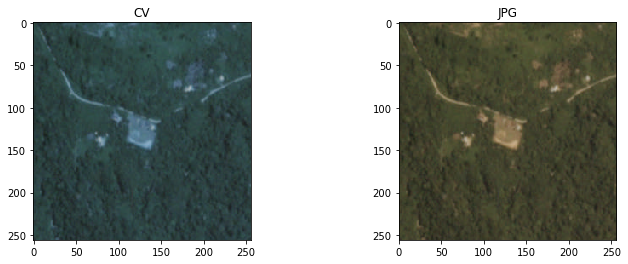

In [27]:
# Plot the bands
m = { "JPG" : im_jpg, "CV" : cv2.cvtColor(im_jpg, cv2.COLOR_BGR2RGB) }
plot_images(m)

In [10]:
# Prepare grid
fig = plt.figure(figsize=(10, 14))
fig.suptitle("im_name", size=20)
gs = gridspec.GridSpec(3, 6, height_ratios=[3, 4, 1])
# Display images
ax_jpg = plt.subplot(gs[0,:3])
ax_jpg.imshow(im_jpg, vmin=0, vmax=255)
ax_jpg.set_title('JPG')

## A few definitions and utility functions

In [2]:


# These parameters controls the percentiles used in the match algorithm:
# percentiles = np.linspace(percentile_eps, 100-percentile_eps, function_resoution)
percentile_eps = 0.5
function_resoution = 32

# Sample images to present results
input_images = ['train_10541', 'train_10142', 'train_1000',
                'train_10577', 'train_10020', 'train_10216',
                'train_1012', 'train_10124', 'train_10348']

load_tif = lambda f: imread(join(tif_folder, f + '.tif'))
load_jpg = lambda f: imread(join(jpg_folder, f + '.jpg'))

## Main function: `match_percentiles`
_See commented code for details_

In [3]:
def match_percentiles(im_name, im_tif, im_jpg):
    # Lineary distribute the percentiles
    percentiles = np.linspace(percentile_eps, 100-percentile_eps, function_resoution)
    
    # Calculate the percentiles for TIF and JPG, one per channel
    x_per_channel = [np.percentile(im_tif[...,c].ravel(), percentiles) for c in range(3)]
    y_per_channel = [np.percentile(im_jpg[...,c].ravel(), percentiles) for c in range(3)]

    # This is the main part: we use np.interp to convert intermadiate values between
    # percentiles from TIF to JPG
    convert_channel = lambda im, c: np.interp(im[...,c], x_per_channel[c], y_per_channel[c])
    
    # Convert all channels, join and cast to uint8 at range [0, 255]
    tif2jpg = lambda im: np.dstack([convert_channel(im, c) for c in range(3)]).clip(0,255).astype(np.uint8)
    
    # The function could stop here, but we are going to plot a few charts about its results
    im_tif_adjusted = tif2jpg(im_tif[...,:3])
    
    # Plot results
    colors = ['red', 'green', 'blue']

    # Prepare grid
    fig = plt.figure(figsize=(10, 14))
    fig.suptitle(im_name, size=20)
    gs = gridspec.GridSpec(3, 6, height_ratios=[3, 4, 1])
    
    # Display images
    ax_jpg = plt.subplot(gs[0,:3])
    ax_jpg.imshow(im_jpg, vmin=0, vmax=255)
    ax_jpg.set_title('JPG')
    
    ax_jpg = plt.subplot(gs[0,3:])
    ax_jpg.imshow(im_tif_adjusted, vmin=0, vmax=255)
    ax_jpg.set_title('TIF')

    # Display response curve
    ax_curves = plt.subplot(gs[1,:])
    ax_curves.set_title('Response curves')
    for c in range(3):
        ax_curves.plot(x_per_channel[c], y_per_channel[c], 'o-', color=colors[c], label=colors[c])

    ax_curves.legend()

    # Detail every channel
    for c in range(3):
        ax = plt.subplot(gs[2,c*2:c*2+2])
        ax.plot(x_per_channel[c][2:-2], y_per_channel[c][2:-2], color=colors[c])
        ax.set_title(colors[c] + ' detail')

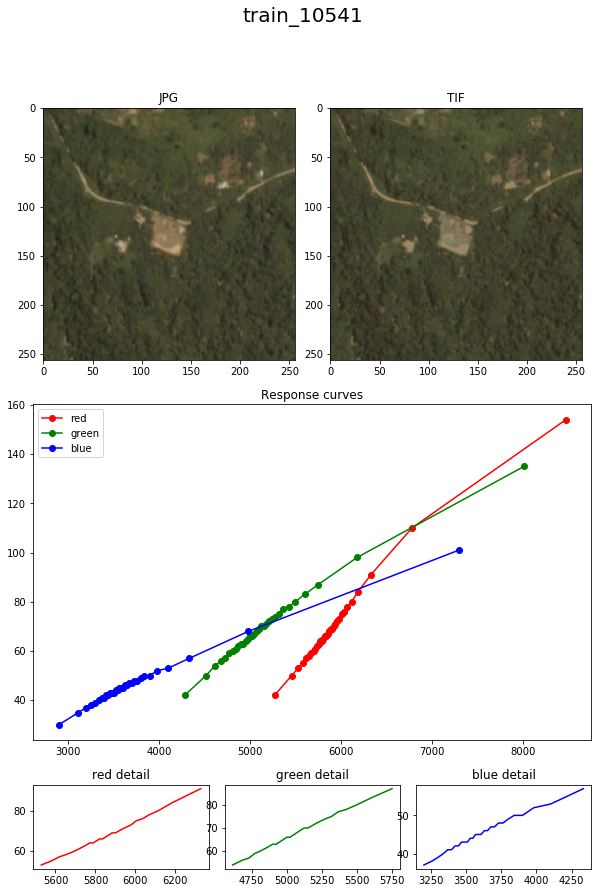

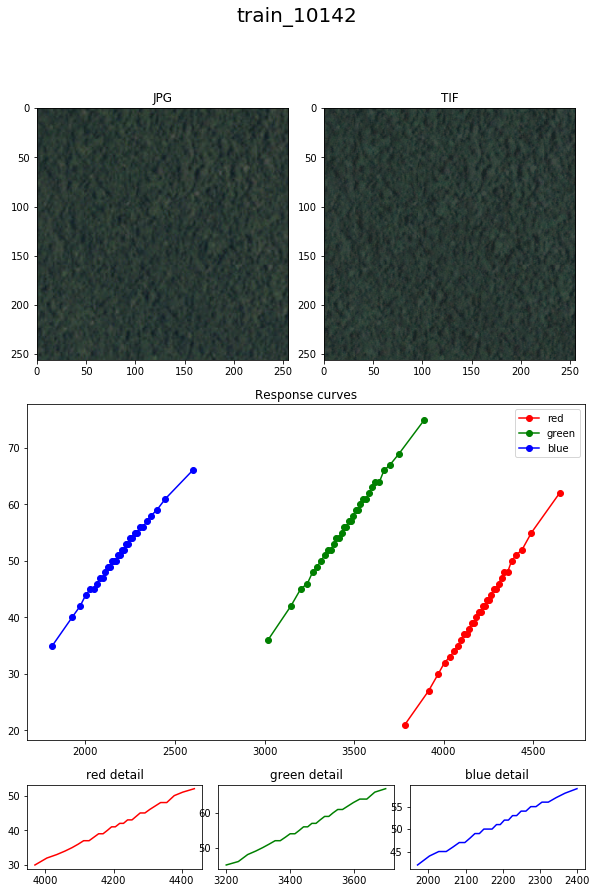

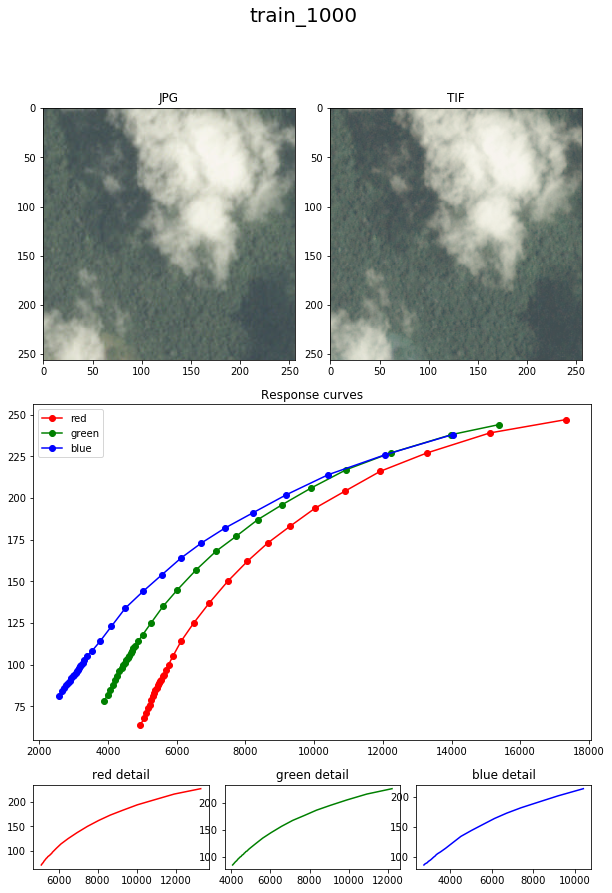

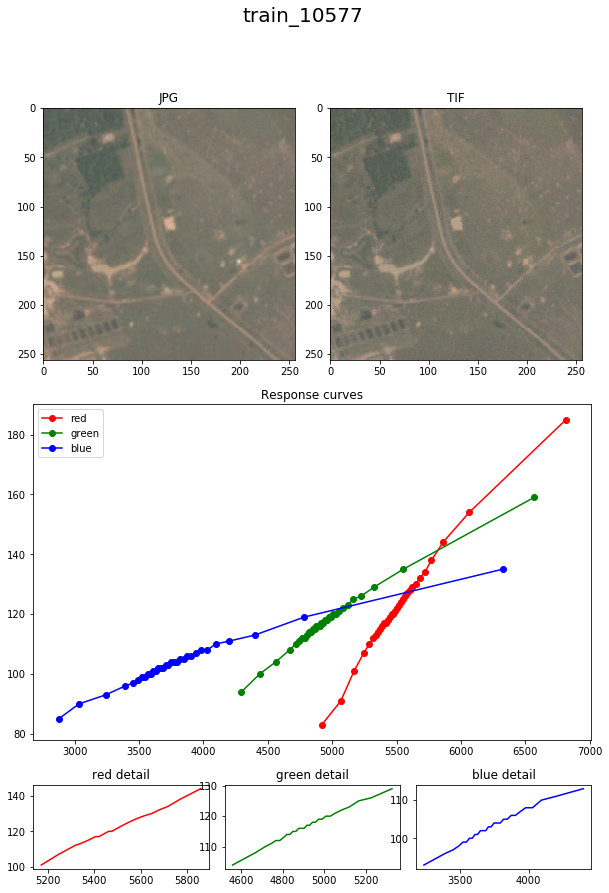

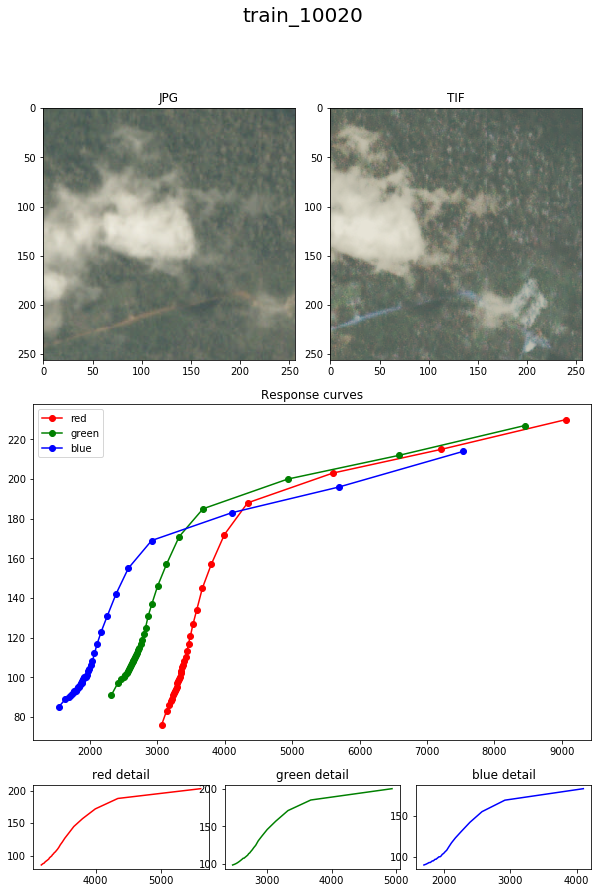

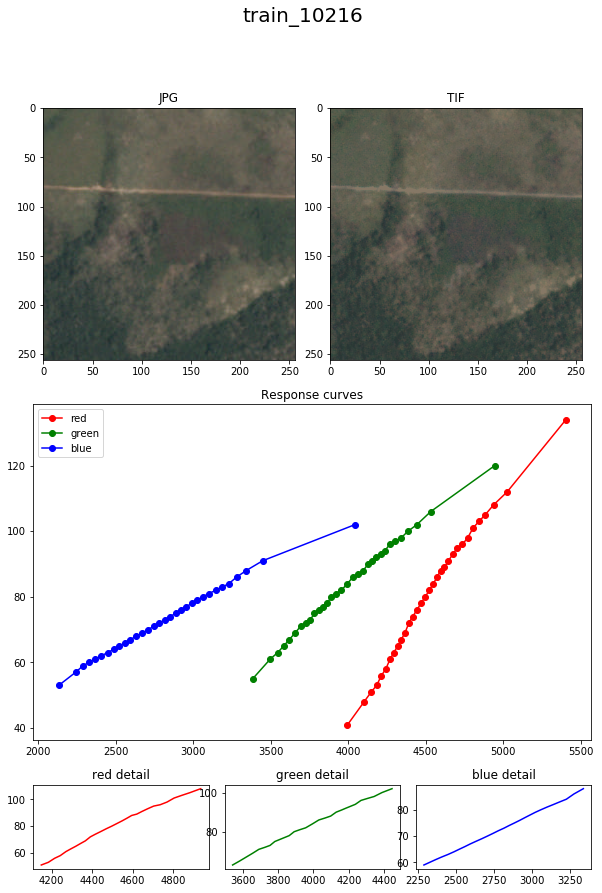

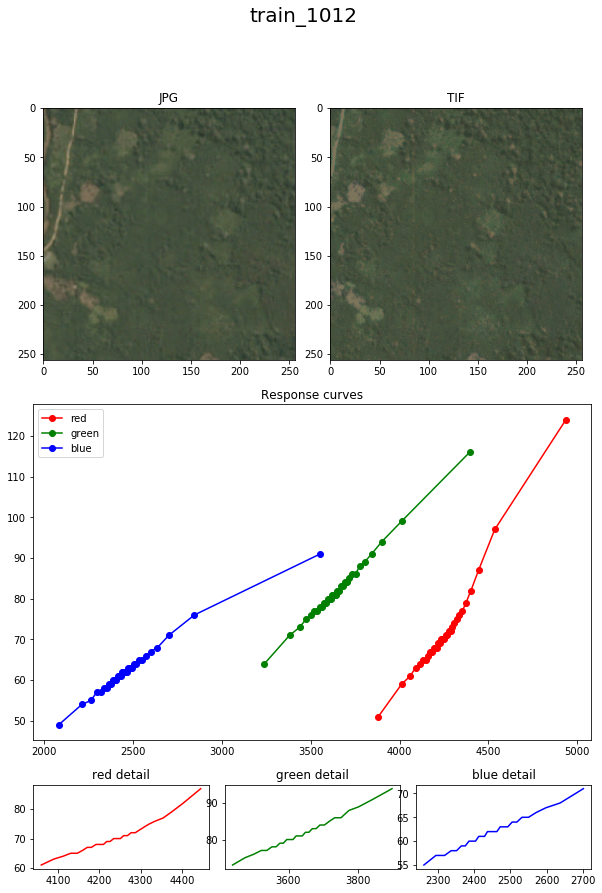

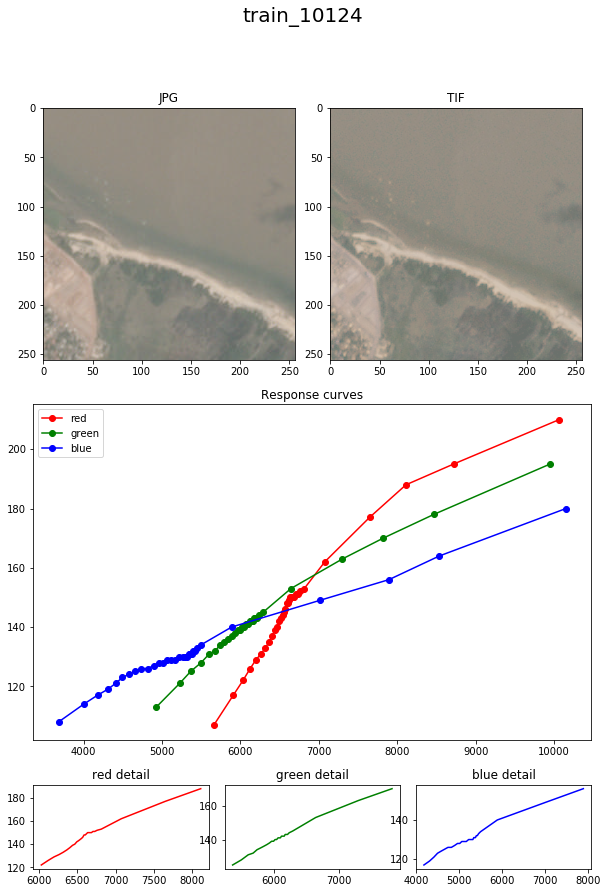

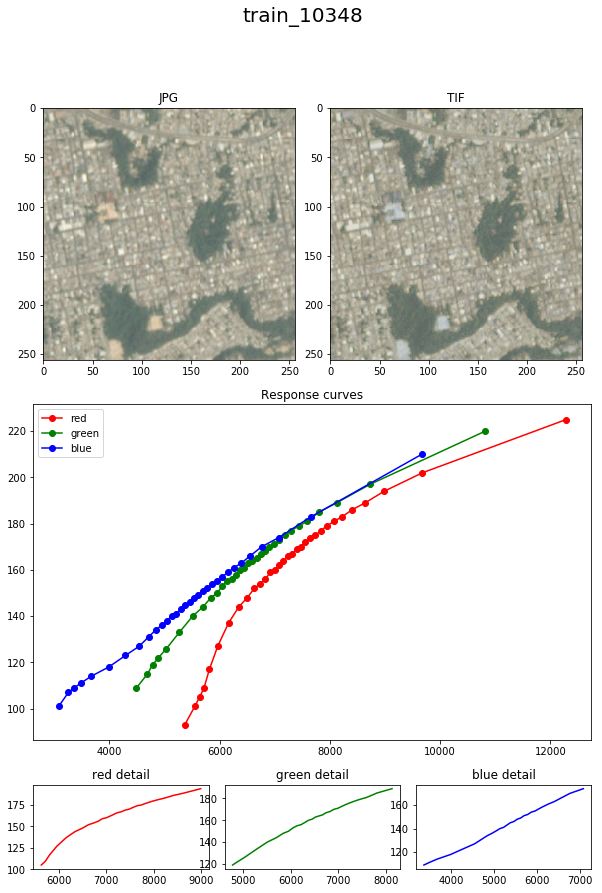

In [4]:
for f in input_images:
    match_percentiles(f, load_tif(f), load_jpg(f))

## Final notes

One of my objectives was to find a global conversion function, but giving the different response curves for each image, I'm not sure if it will work.

I also tried to find a local conversion function (matching the pixels from TIF to JPG), but giving that not all images are perfectly aligned (as 'train_1012'), this became a more difficult task.

_Please upvote this notebook if you find it interesting/useful. Thanks!_